# **Data Cleaning Notebook**

## Objectives

* Further data exploration
* Evaluate missing data
* Decide on imputation methods for missing data
* Split the data into Train and Test sets.

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate cleaned Train and Test sets, saved under outputs/datasets/cleaned 

## Additional Comments

* CRISP-DM: *Data Understanding/Preparation* 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing'

---

Import all necessary packages and libraries for the notebook

In [6]:
import os
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
sns.set(style="whitegrid")

# Load Collected Data

Section 1 content

In [7]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Data Exploration

Reviweing the list of columns with missing data

In [8]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [9]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/tmp/ipykernel_1399/3398083222.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Observation:
* in total 9 columns are missing data 
* a total of approx.. 26% of cells are missing data.
* some of the variables with missing values also have too many zeros.

---

## Correlation and PPS Analysis

We carry out an initial assessment of the relationship between the different variables/features/data.

Custom functions used to calculate the Pearson and Spearman coefficients, and the PPS are taken from Code Institute's "Churnometer" walkthrough project.

In [10]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [11]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



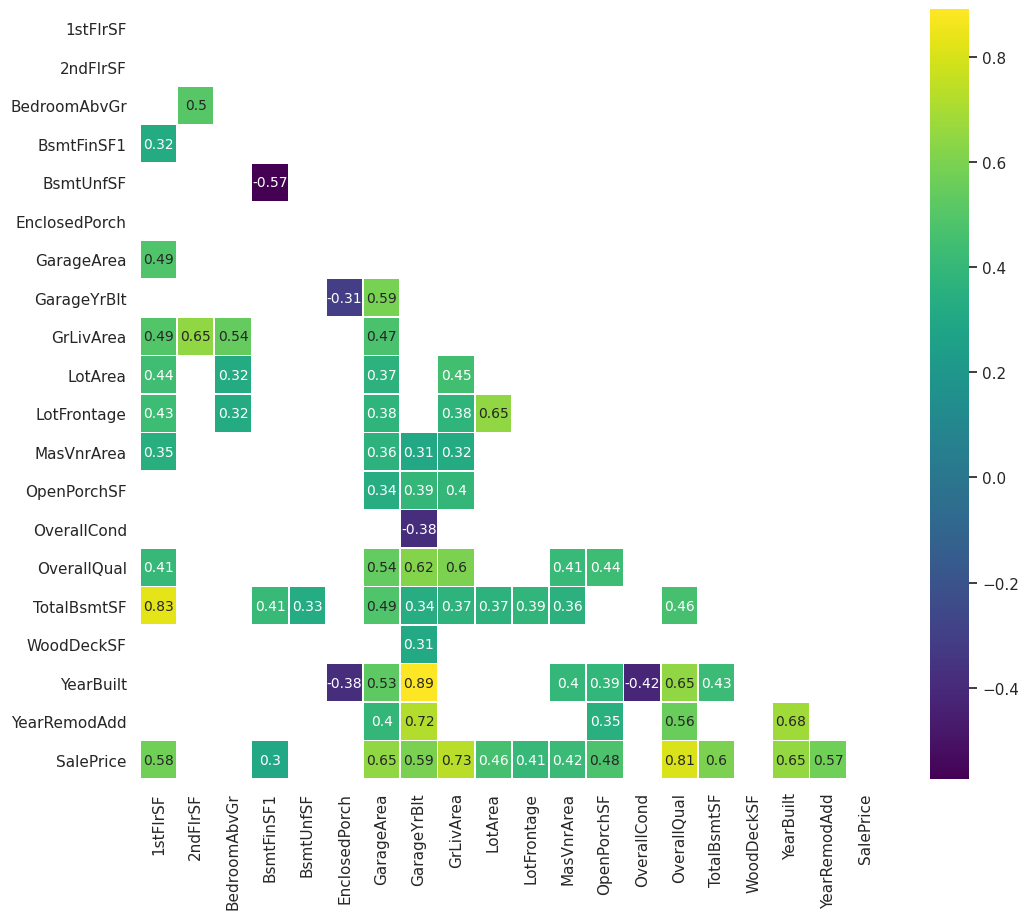



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



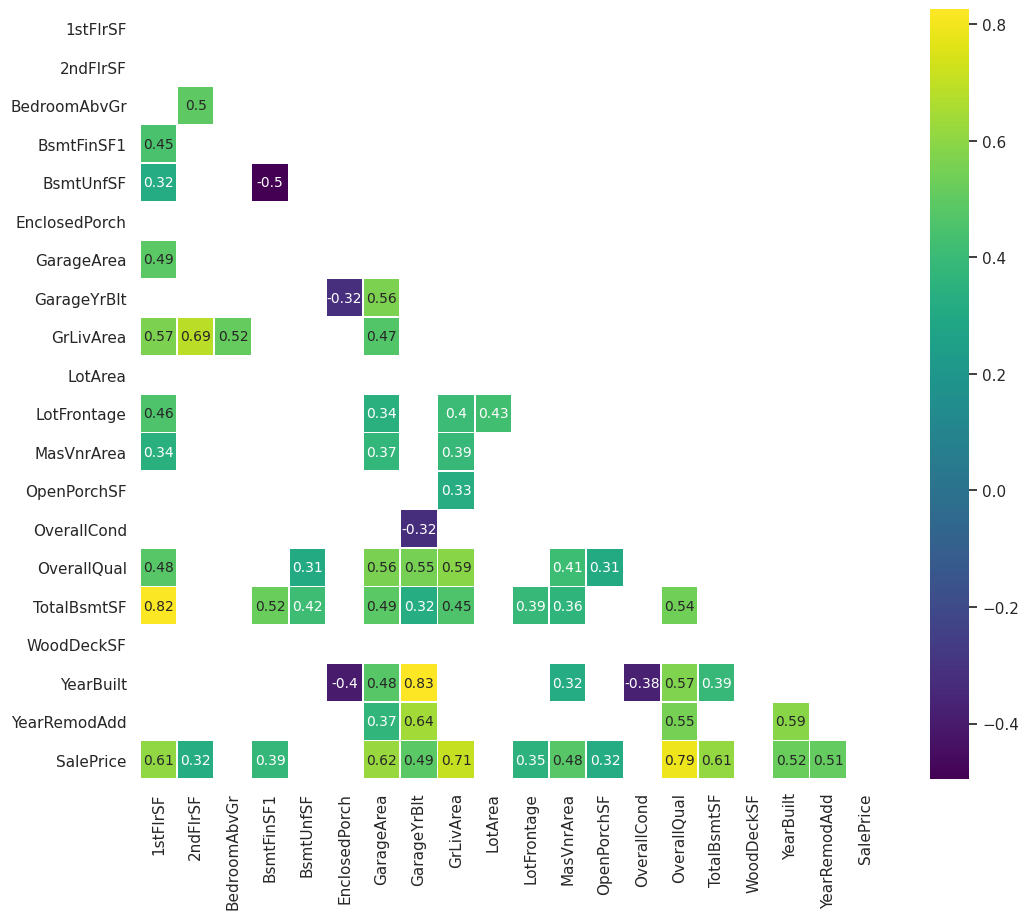



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



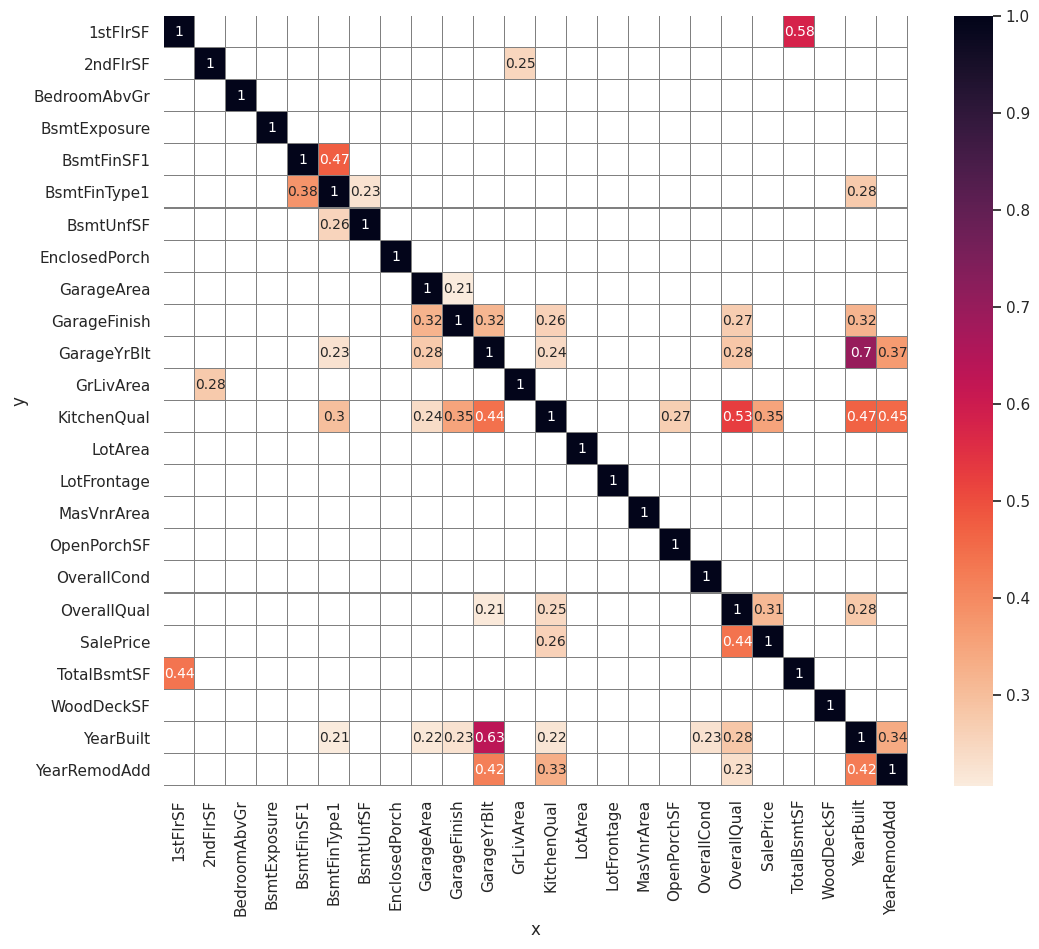

In [12]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)

---

# Data Cleaning

## Assessing Missing Data Levels

* Custom function to display missing data levels in a dataframe, it shows the aboslute levels, relative levels and data type

In [13]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
        data={"RowsWithMissingData": missing_data_absolute,
              "PercentageOfDataset": missing_data_percentage,
              "DataType": df.dtypes}
    )
                       .sort_values(by=['PercentageOfDataset'], ascending=False)
                       .query("PercentageOfDataset > 0")
                      )
    return df_missing_data

EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Data Cleaning Spreadsheet Summary

After reviewing the missing data levels and analysis of variables in the context of the business case, we want to preserve as much of it as possible and instead of dropping data instances or deleting variables from the data set. 

The following approaches will be tried to deal with missing data. A spreadsheet was used to record potential data cleaning approaches during development Heritage Housing Spreadsheet

| Variables | Observations | Possible Approach |
| :---------:| :---------: | :--------: |
| 'EnclosedPorch' | About 90% of data missing. The reason could be the non existence of a enclosed porch or data may not have been inputed due to user error | DROP |
| 'WoodDeckSF' | Also has a large portion of missing data (89.38%). The reason could be the non existence of a wood deck or data may not have been inputed due to user error | DROP |
| 'BedroomAbvGr'| The data have a mean of 2.9, a median of 3 and a std of 0.8. Noted that the distribution look fairly close to the normal distribution| Imputation - Mean |
| '2ndFlrSF' | There is a possibility that some houses do not have a second floor - 53.5% of data is a zero. Therefore one may assume that imputing the null values with 0 would add value.   | Arbitrary Number Imputation |
| 'GarageYrBlt' | Data could be missing for some houses that do not have garages, therefore this data may have intentionally been missed. Although we could just imput zero to add value, this would not be valid because we cannot imput a year to a garage that does not exist.  | Imputation - Median or DROP |
| 'LotFrontage' |  By checking the distribution of this variable, we found that it has a slight positive skew and strong positive kurtosis. It is therefore not normally distributed and we should impute the median. | Arbitrary Number Imputation |
| 'MasVnrArea' | Most values for this variable are 0 indicating that there is no masonry veneer. Accordingly, we can assume that missing variables indicate the absence of a masonry veneer, so we can impute 0 as a value here. | Arbitrary Number Imputation |
| 'GarageFinish' | A little over 10% of the data is missing because some entries are 0, meaning there is no garage. A few approaches should be consider here such as use the machine model to predict  the GarageFinish based on other available variables present but for now we will simply impute an arbitrary value of "unf" to represent unfinished.  | Categorical Imputation ('unf') |
| 'BsmtFinType1' | Similar reasons to those listed for 'GarageFinish'. For now, we will simply impute an arbitrary value of "unf" to represent unfinished.| Categorical Imputation ('unf') |

## Dealing with Missing Data

The function used to assess the effect of the cleaning process is taken from Code Institute's lessons on Feature Engine:

In [14]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

### Data Cleaning Summary

* Drop : ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
* Arbitrary Number Imputation : ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
* Mean Imputation : ['BedroomAbvGr', ]
* Categorical Imputation : ['GarageFinish', 'BsmtFinType1']

### Drop Variables

In [ ]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt' ]
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)

### Arbitrary Number Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'MasVnrArea', 'LotFrontage'] 




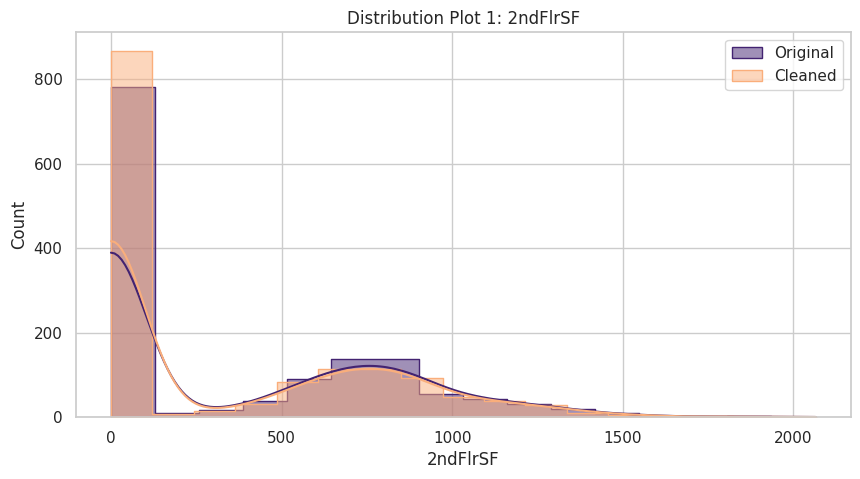

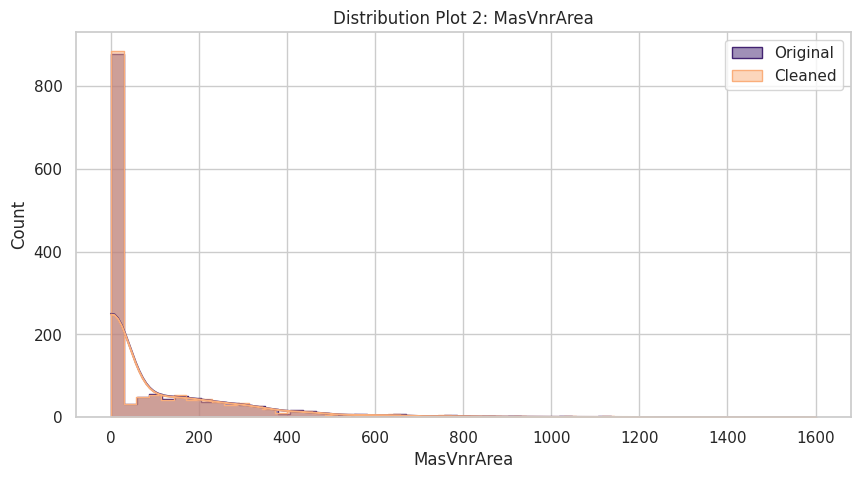

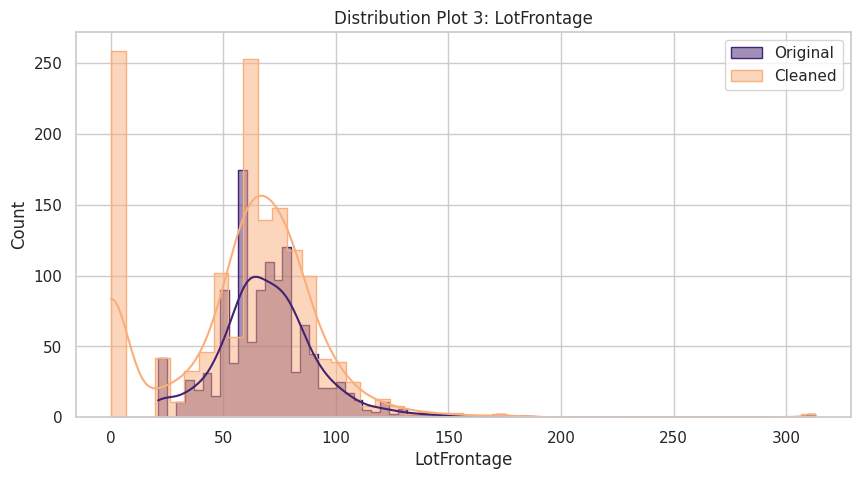

In [20]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['2ndFlrSF', 'MasVnrArea', 'LotFrontage']
variables_method

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Mean Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BedroomAbvGr'] 




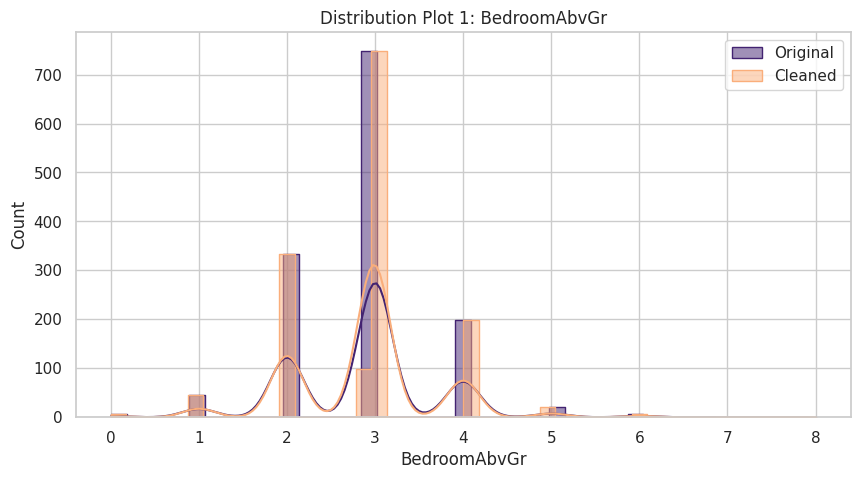

In [21]:
variables_method = ['BedroomAbvGr']
variables_method


imputer = MeanMedianImputer(imputation_method='mean', variables=variables_method)
                            
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Categorical Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




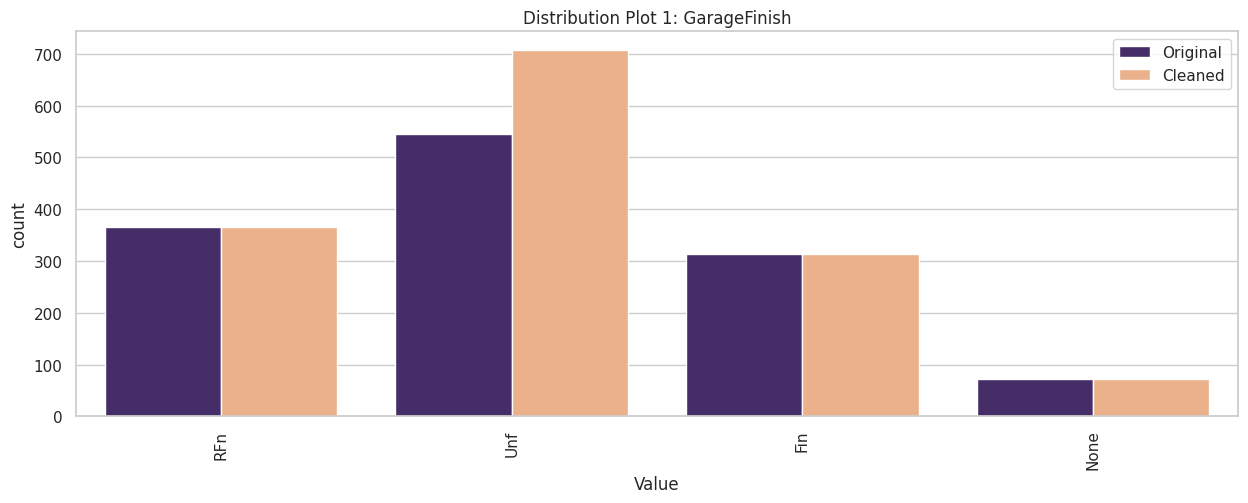

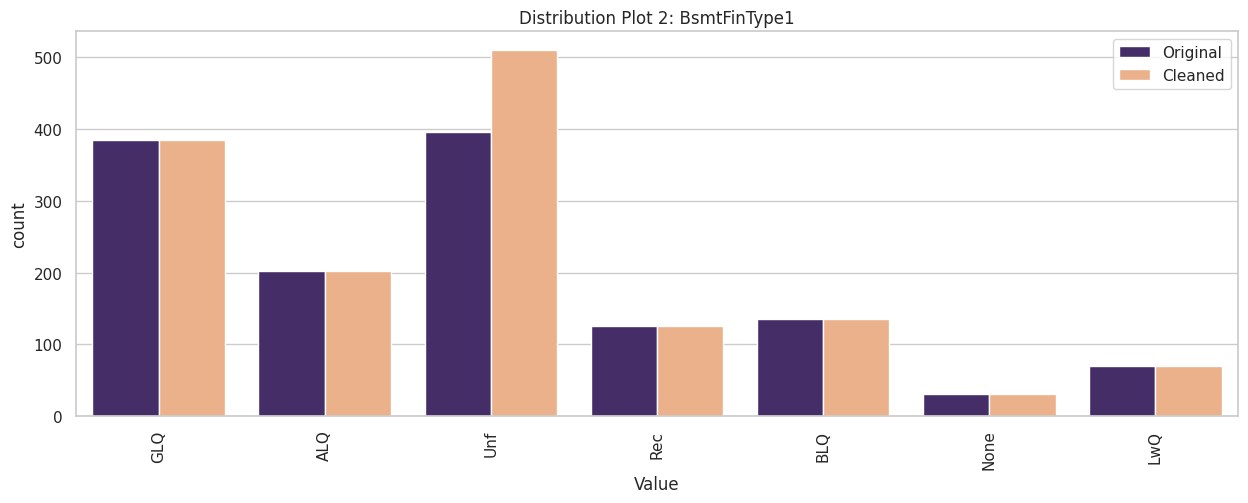

In [18]:

from feature_engine.imputation import CategoricalImputer

variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Train and Test Split

* Next we split the data into train and test sets

In [19]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


* Now we apply the changes from the various imputation methods to the train and test sets.

In [22]:
# Drop Variables ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
variables_method = ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

# Arbitrary Number Imputer 
variables_method = ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# Mean Imputer
variables_method = ['BedroomAbvGr']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# Categorical Imputation
variables_method = ['BsmtFinType1', 'GarageFinish']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)


* Evaluate missing data one more time

In [23]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


### Data Cleaning Pipeline

In [24]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer


data_cleaning_pipeline = Pipeline([
      ( 'DropFeatures', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']) ),
      ( 'ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea']) ),
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr']) ),
      ( 'CategoricalImputer', CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish']) ),
      
])

df = data_cleaning_pipeline.fit_transform(df)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1717,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2198,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [25]:
try:
  # create here your folder
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

# Save the Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

# Save the Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)